# Bayesian Optimization Example Using `mlos_core`

In [165]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [166]:
# Define a fake "performance" function.
# In an actual application, we would not have access to this function directly.
# Instead, we could only measure the outcome by running an experiment, such as timing
# a particular run of the system.
def f(x):
    return (6*x-2)**2*np.sin(12*x-4)

Text(0, 0.5, 'Objective (i.e. performance)')

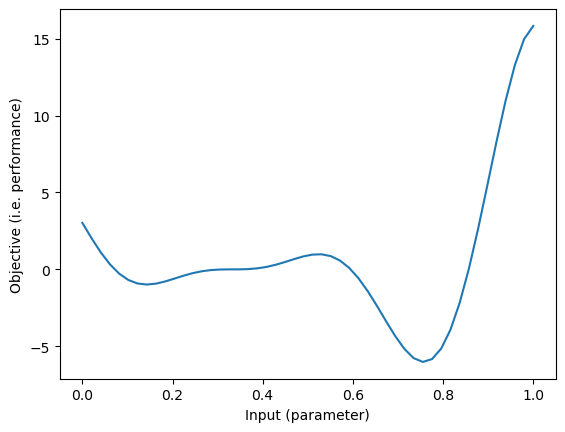

In [167]:
# define a domain to evaluate
line = np.linspace(0, 1)
# evaluate the function
values = f(line)
# plot the function
plt.plot(line, values)
plt.xlabel("Input (parameter)")
plt.ylabel("Objective (i.e. performance)")

In [168]:
import ConfigSpace as CS

# Start defining a ConfigurationSpace for the Optimizer to search.
input_space = CS.ConfigurationSpace(seed=1234)

# Add a single continuous input dimension between 0 and 1.
input_space.add_hyperparameter(CS.UniformFloatHyperparameter(name='x', lower=0, upper=1))

x, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5

In [169]:
import mlos_core.optimizers

In [170]:
# Choose an optimizer.

#optimizer = mlos_core.optimizers.RandomOptimizer(parameter_space=input_space)

#optimizer = mlos_core.optimizers.FlamlOptimizer(parameter_space=input_space)

optimizer = mlos_core.optimizers.SmacOptimizer(parameter_space=input_space) # , seed=42, n_random_init=20)

[INFO][abstract_initial_design.py:82] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:147] Using 10 initial design configurations and 0 additional configurations.


In [171]:
# Inspect the chosen optimizer
optimizer

SmacOptimizer(parameter_space=Configuration space object:
  Hyperparameters:
    x, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
)

Now, we can run the actual optimization which will carry out the steps outlined above.

In [172]:
def run_optimization(optimizer: mlos_core.optimizers.BaseOptimizer):
    # get a new config value suggestion to try from the optimizer.
    suggested_value = optimizer.suggest()
    # suggested value are dictionary-like, keys are input space parameter names
    # evaluate target function
    target_value = f(suggested_value['x'])
    print(suggested_value, "\n", target_value)
    optimizer.register(suggested_value, target_value)

# run for some iterations
n_iterations = 15
for i in range(n_iterations):
    run_optimization(optimizer)

[INFO][abstract_intensifier.py:305] Using only one seed for deterministic scenario.
          x
0  0.529394 
 0    0.981903
Name: x, dtype: float64
[INFO][abstract_intensifier.py:515] Added config 046b02 as new incumbent because there are no incumbents yet.
          x
0  0.412449 
 0    0.183208
Name: x, dtype: float64
[INFO][abstract_intensifier.py:590] Added config 6c9ddf and rejected config 046b02 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][configspace.py:175] --- x: 0.5293941991008323 -> 0.4124485902231257
          x
0  0.137717 
 0   -0.982619
Name: x, dtype: float64
[INFO][abstract_intensifier.py:590] Added config 6c38e4 and rejected config 6c9ddf as incumbent because it is not better than the incumbents on 1 instances:
[INFO][configspace.py:175] --- x: 0.4124485902231257 -> 0.13771684308449206
          x
0  0.965271 
 0    13.852784
Name: x, dtype: float64
          x
0  0.072383 
 0   -0.024966
Name: x, dtype: float64
          x
0  0.220

After 15 iterations, the model is likely to have captured the general shape, but probably not have found the actual optimum since the first few iterations are spent randomly exploring the space.

In [173]:
optimizer.get_observations()

,x,score
0,0.529394,0.981903
0,0.412449,0.183208
0,0.137717,-0.982619
0,0.965271,13.852784
0,0.072383,-0.024966
0,0.220613,-0.446572
0,0.384809,0.055248
0,0.724267,-5.500623
0,0.650459,-2.230947
0,0.811740,-4.252442


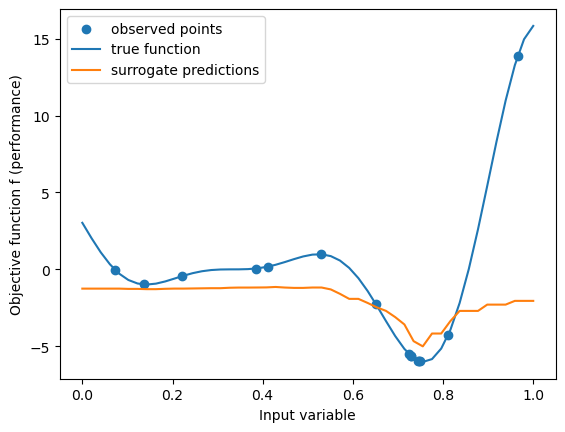

In [174]:
# evaluate the surrogate function
#
configs = pd.DataFrame(line.reshape(-1, 1), columns=['x'])
surrogate_predictions = optimizer.surrogate_predict(configs)

# plot the observations
#
observations = optimizer.get_observations()
plt.scatter(observations.x, observations.score, label='observed points')

# plot the true function (usually unknown)
#
plt.plot(line, values, label='true function')

# plot the surrogate
#
# alpha = optimizer_config.experiment_designer_config.confidence_bound_utility_function_config.alpha
# t_values = t.ppf(1 - alpha / 2.0, surrogate_predictions['predicted_value_degrees_of_freedom'])
# ci_radii = t_values * np.sqrt(surrogate_predictions['predicted_value_variance'])
# value = surrogate_predictions['predicted_value']
plt.plot(line, surrogate_predictions, label='surrogate predictions')
#plt.fill_between(line, value - ci_radii, value + ci_radii, alpha=.1)
#plt.plot(line, -optimizer.experiment_designer.utility_function(optimization_problem.construct_feature_dataframe(pd.DataFrame({'x': line}))), ':', label='utility_function')
plt.ylabel("Objective function f (performance)")
plt.xlabel("Input variable")
plt.legend()
plt.show()

We can find the best value according to the current surrogate with the ``optimum`` method:

In [175]:
optimizer.get_best_observation()

,x,score
0,0.74826,-5.978736


We can run more iterations to improve the surrogate model and the optimum that is found:

In [176]:
# run for more iterations
n_iterations = 50
for i in range(n_iterations):
    run_optimization(optimizer)

          x
0  0.760236 
 0   -6.015935
Name: x, dtype: float64
[INFO][abstract_intensifier.py:590] Added config 314671 and rejected config 600943 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][configspace.py:175] --- x: 0.7482599645068192 -> 0.7602360169805238
          x
0  0.767468 
 0   -5.963419
Name: x, dtype: float64
          x
0  0.760029 
 0   -6.016581
Name: x, dtype: float64
[INFO][abstract_intensifier.py:590] Added config 225bde and rejected config 314671 as incumbent because it is not better than the incumbents on 1 instances:
[INFO][configspace.py:175] --- x: 0.7602360169805238 -> 0.7600285216804508
          x
0  0.759498 
 0   -6.01802
Name: x, dtype: float64
[INFO][abstract_intensifier.py:590] Added config 5ad459 and rejected config 225bde as incumbent because it is not better than the incumbents on 1 instances:
[INFO][configspace.py:175] --- x: 0.7600285216804508 -> 0.7594984647988082
          x
0  0.758829 
 0   -6.019401
Name: x, 

There is some improvement in the optimum:

In [177]:
optimizer.get_best_observation()

,x,score
0,0.75725,-6.02074


We can now visualize the surrogate model and optimization process again. The points are colored according to the iteration number, with dark blue points being early in the process and yellow points being later. You can see that at the end of the optimization, the points start to cluster around the optimum.
The region to the right is not explored much because the surrogate model predicts that it is not likely to contain the optimum and hence also doesn't have as much accuracy compared to the real function there.

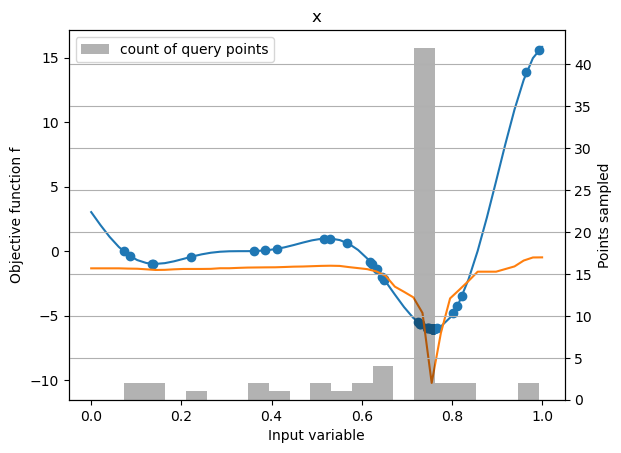

In [178]:
# evaluate the surrogate function
#
configs = pd.DataFrame(line.reshape(-1, 1), columns=['x'])
surrogate_predictions = optimizer.surrogate_predict(configs)

# plot the observations
#
observations = optimizer.get_observations()
plt.scatter(observations.x, observations.score, label='observed points')

# plot true function (usually unknown)
#
plt.plot(line, values, label='true function')

# plot the surrogate
#
#ci_raduii = surrogate_predictions['prediction_ci']
plt.plot(line, surrogate_predictions, label='surrogate predictions')
#plt.fill_between(line, value - ci_radii, value + ci_radii, alpha=.1)
#plt.plot(line, -optimizer.utility_function(pd.DataFrame({'x': line})), ':', label='utility_function')

ax = plt.gca()
ax.set_ylabel("Objective function f")
ax.set_xlabel("Input variable")
bins_axes = ax.twinx()
bins_axes.set_ylabel("Points sampled")
pd.DataFrame(observations.x).hist(bins=20, ax=bins_axes, alpha=.3, color='k', label="count of query points")
plt.legend()